In [1]:
import time
import os, sys
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import torch
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
from argparse import ArgumentParser, Namespace
import cv2
from tqdm import tqdm
from arguments import ModelParams, PipelineParams, ModelHiddenParams
from scene import Scene, GaussianModel
from utils.sh_utils import SH2RGB, RGB2SH
import imageio
from utils.segment_utils import *
import math
from diff_gaussian_rasterization import GaussianRasterizationSettings, GaussianRasterizer

%load_ext autoreload
%autoreload 2

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
@torch.no_grad()
def render(viewpoint_camera, pc : GaussianModel, bg_color: torch.Tensor, recolor = None):
    
    # Create zero tensor. We will use it to make pytorch return gradients of the 2D (screen-space) means
    screenspace_points = torch.zeros_like(pc.get_xyz, dtype=pc.get_xyz.dtype, requires_grad=True, device="cuda") + 0
    try:
        screenspace_points.retain_grad()
    except:
        pass

    # Set up rasterization configuration
    means3D = pc.get_xyz
    tanfovx = math.tan(viewpoint_camera.FoVx * 0.5)
    tanfovy = math.tan(viewpoint_camera.FoVy * 0.5)
    scaling_modifier = 1.0
    raster_settings = GaussianRasterizationSettings(
        image_height=int(viewpoint_camera.image_height),
        image_width=int(viewpoint_camera.image_width),
        tanfovx=tanfovx,
        tanfovy=tanfovy,
        bg=bg_color,
        scale_modifier=scaling_modifier,
        viewmatrix=viewpoint_camera.world_view_transform.cuda(),
        projmatrix=viewpoint_camera.full_proj_transform.cuda(),
        sh_degree=pc.active_sh_degree,
        campos=viewpoint_camera.camera_center.cuda(),
        prefiltered=False,
        debug=False
    )
    time = torch.tensor(viewpoint_camera.time).to(means3D.device).repeat(means3D.shape[0],1)
        
    rasterizer = GaussianRasterizer(raster_settings=raster_settings)

    means2D = screenspace_points
    opacity = pc._opacity
    shs = pc.get_features
    scales = pc._scaling
    rotations = pc._rotation
    means3D_final, scales_final, rotations_final, opacity_final, _ = pc._deformation(means3D, scales, rotations, opacity, shs, time)
    scales_final = pc.scaling_activation(scales_final)
    rotations_final = pc.rotation_activation(rotations_final)
    opacity = pc.opacity_activation(opacity_final)
    
    # recolor masked Gaussians
    if recolor is not None:
        diff = torch.abs(pc._time_map - viewpoint_camera.time)
        index = torch.argmin(diff)
        mask = pc._mask_table[index].bool()
        recolor = recolor.to(shs)
        shs[mask, 0, :] = (1 - 0.5) * shs[mask, 0, :] + recolor * 0.5
        # shs[mask, 0, :] = (1 - 0.5) * shs[mask, 0, :] + recolor(shs[mask, 0, :]) * 0.5
    
    # Rasterize visible Gaussians to image, obtain their radii (on screen). 
    rendered_image, _, _, _ = rasterizer(
        means3D = means3D_final,
        means2D = means2D,
        shs = shs,
        colors_precomp = None,
        opacities = opacity,
        mask = torch.zeros((means3D_final.shape[0], 1), dtype=torch.float, device="cuda"),
        scales = scales_final,
        rotations = rotations_final,
        cov3D_precomp = None)
   
    return rendered_image

In [3]:
DATA_ROOT = './data/dynerf/flame_steak'
MODEL_PATH = './output/dynerf/flame_steak'
CFG_PATH = './arguments/dynerf/flame_steak.py'

In [4]:
parser = ArgumentParser(description="Render script parameters")
model = ModelParams(parser, sentinel=True)
# op = OptimizationParams(parser)
pipeline = PipelineParams(parser)
hp = ModelHiddenParams(parser)
parser.add_argument("--iteration", default=-1, type=int)
parser.add_argument('--mode', default='scene', choices=['scene', 'feature'])
parser.add_argument("--configs", type=str, default = CFG_PATH)
# parser.add_argument('--precomputed_mask', default=None, type=str)
args = get_combined_args(parser, MODEL_PATH, 'scene')
if args.configs:
    import mmcv
    from utils.params_utils import merge_hparams
    config = mmcv.Config.fromfile(args.configs)
    args = merge_hparams(args, config)

dataset = model.extract(args)
hyperparam = hp.extract(args)
dataset.object_masks = False
dataset.need_gt_masks = False

gaussians = GaussianModel(dataset.sh_degree, 'scene', hyperparam)
scene = Scene(dataset, gaussians, load_iteration=args.iteration, mode='scene', cam_view="cam03")
gaussians.load_mask_table(os.path.join(MODEL_PATH, "segment_results", "dog.pt"))

Looking for config file in ./output/dynerf/flame_steak/cfg_args
Config file found at: ./output/dynerf/flame_steak/cfg_args
mode:  scene
Loading trained model at iteration 14000
meta data loaded, total image:300
meta data loaded, total image:300
load finished. Train Dataset Length: 300


100%|██████████| 300/300 [00:00<00:00, 168875.48it/s]
300it [00:00, 63546.85it/s]


origin points, 37765
after points, 37765
Loading Training Cameras
Loading Test Cameras
Loading Video Cameras
Deformation Net Set aabb [20.96438789 14.43809223 42.81179047] [-27.41521454 -18.42700958   6.00896609]
Voxel Plane: set aabb= Parameter containing:
tensor([[ 20.9644,  14.4381,  42.8118],
        [-27.4152, -18.4270,   6.0090]])
loading model from exists./output/dynerf/flame_steak/point_cloud/iteration_14000


In [5]:
bg_color = [1, 1, 1] if dataset.white_background else [0, 0, 0]
bg_color = torch.tensor(bg_color, dtype=torch.float32, device="cuda")

train_cams = [i for i in scene.getTrainCameras()]
video_cameras = [i for i in scene.getVideoCameras()]
cam_type = scene.dataset_type
print("train views:", len(train_cams))
print("video views:",len(video_cameras))

train views: 300
video views: 300


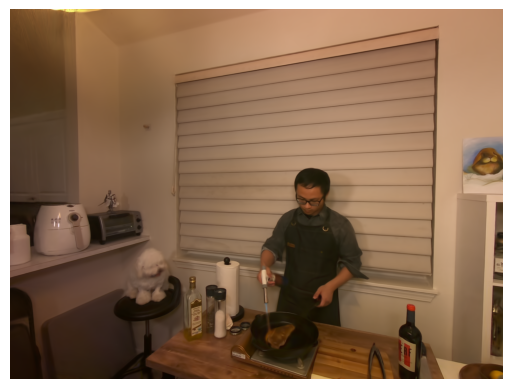

In [6]:
ref_view = train_cams[0]

with torch.no_grad():
    rendering = render(ref_view, gaussians, bg_color, recolor=None)
    img = to8b(rendering).transpose(1,2,0)
    plt.imshow(img)
    plt.axis('off')


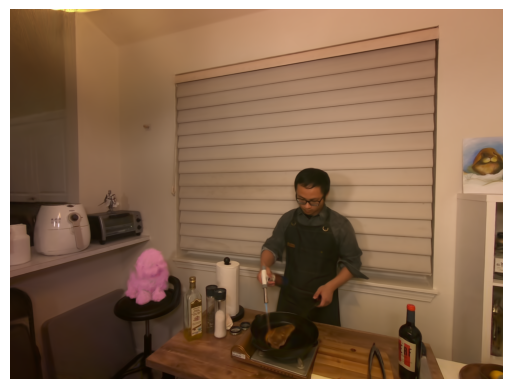

In [10]:
ref_view = train_cams[0]

color_func = lambda color: color[..., [2,1,0]]
recolor = RGB2SH(torch.tensor([255, 105, 180])/255)
with torch.no_grad():
    rendering = render(ref_view, gaussians, bg_color, recolor=recolor)
    # rendering = render(ref_view, gaussians, bg_color, recolor=color_func)
    img = to8b(rendering).transpose(1,2,0)
    plt.imshow(img)
    plt.axis('off')


In [12]:
render_images = []
for idx, view in enumerate(tqdm(video_cameras, desc="Rendering progress")):
    rendering = render(view, gaussians, bg_color, recolor=recolor)
    render_images.append(to8b(rendering.detach()).transpose(1,2,0))

imageio.mimwrite('demo/recolor_dog_1.mp4', render_images, fps=30)

Rendering progress:   0%|          | 0/300 [00:00<?, ?it/s]

Rendering progress: 100%|██████████| 300/300 [00:07<00:00, 41.23it/s]
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1352, 1014) to (1360, 1024) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x71b6f40] Warning: data is not aligned! This can lead to a speed loss


: 

In [117]:
type(video_cameras[1].time)

float

In [127]:
video_time = torch.linspace(180.0/525, 240.0/525, 90)
# print(video_time)

In [136]:
range(180, 240)[59]

239

In [210]:
from utils.segment_utils import *

render_images = []
for idx, t in enumerate(tqdm(range(150, 390), desc="Rendering progress")):
    if idx == 0: time1 = time.time()
    
    # nearest interpolate
    diff = torch.abs(gaussians._time_map - video_cameras[t].time)
    index = torch.argmin(diff)
    mask = gaussians._mask_table[index]
        
    rendering = render_segmentation(video_cameras[t], gaussians, pipeline, bg_color, mask.bool())["render"]
    render_images.append(to8b(rendering.detach()).transpose(1,2,0))

time2 = time.time()
print("FPS:", len(video_cameras) / (time2 - time1))
torch.cuda.empty_cache()
    
imageio.mimwrite('demo/seg_americano_trunc.mp4', render_images, fps=30)

Rendering progress:   0%|          | 0/240 [00:00<?, ?it/s]

Rendering progress: 100%|██████████| 240/240 [00:01<00:00, 128.04it/s]
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (536, 960) to (544, 960) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


FPS: 280.4885368852834


[swscaler @ 0x589af40] Warning: data is not aligned! This can lead to a speed loss


In [126]:
from utils.segment_utils import *

render_images = []
for idx, t in enumerate(tqdm(video_time, desc="Rendering progress")):
    if idx == 0: time1 = time.time()
    
    # nearest interpolate
    diff = torch.abs(gaussians._time_map - t)
    index = torch.argmin(diff)
    mask = gaussians._mask_table[index]
        
    rendering = render_segmentation(video_cameras[idx], gaussians, pipeline, bg_color, mask.bool(), t)["render"]
    render_images.append(to8b(rendering.detach()).transpose(1,2,0))

time2 = time.time()
print("FPS:", len(video_cameras) / (time2 - time1))
torch.cuda.empty_cache()
    
imageio.mimwrite('demo/seg_americano_interp.mp4', render_images, fps=30)

Rendering progress:   0%|          | 0/180 [00:00<?, ?it/s]

Rendering progress: 100%|██████████| 180/180 [00:01<00:00, 122.00it/s]
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (536, 960) to (544, 960) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


FPS: 356.3815566490113


[swscaler @ 0x74acf40] Warning: data is not aligned! This can lead to a speed loss


## Quantative Results

In [ ]:
test_views = [i for i in scene.getTestCameras()]

In [ ]:
target_view = test_views[0]
with torch.no_grad():
    diff = torch.abs(gaussians._time_map - target_view.time)
    index = torch.argmin(diff)
    mask = gaussians._mask_table[index]

    target_seg = render_segmentation(target_view, gaussians, pipeline, bg_color, mask.bool())["render"]
    target_img_seg = to8b(target_seg.detach()).transpose(1,2,0)
    rendered_mask = render_mask(target_view, gaussians, pipeline, bg_color, precomputed_mask=mask.float())["mask"]
    rendered_mask = rendered_mask.squeeze().detach().cpu() > 0.1
plt.subplot(1, 3, 1)
plt.imshow(target_img_seg)
plt.axis("off")
plt.subplot(1, 3, 2)
plt.imshow(rendered_mask)
plt.axis("off")
plt.subplot(1, 3, 3)
plt.imshow(target_view.gt_mask.squeeze().int())
plt.axis('off')
plt.show()

In [ ]:
miou = 0.
macc = 0.
for idx, view in enumerate(tqdm(test_views)):
     #! render
     rendered_mask = render_mask(view, gaussians, pipeline, bg_color, precomputed_mask=final_mask3d.float())["mask"]
     rendered_mask = rendered_mask.squeeze().detach().cpu() > 0.5
     # rendered_mask = rendered_mask.int()

     gt_mask = view.gt_mask.bool()
     
     #! metrics
     iou = (rendered_mask & gt_mask).sum() / (rendered_mask | gt_mask).sum()
     # iou += ((~rendered_mask) & (~gt_mask)).sum() / ((~rendered_mask) | (~gt_mask)).sum()
     # iou /= 2
     acc = (rendered_mask == gt_mask).count_nonzero() / gt_mask.numel()
     miou += iou
     macc += acc
     # print(miou)
     # break
     
     torch.cuda.empty_cache()

miou /= len(test_views)
macc /= len(test_views)
print("mIoU: %.4f" % (miou * 100))
print("mAcc: %.4f" % (macc * 100))